#Convolutional Autoencoder with Fashion MNIST
This model's use of convolutional layers should result in better encoding / decoding performance

##Imports 



In [3]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

#Prepare the dataset

Notice that the images aren't flattened this time since the 2D-ness will be needed so that the convolutional layers can extract the features.

In [4]:
def map_images(image, label):
  """
  Normalizes the image 

  Returns:
    images as inputs and labels 
  """

  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [5]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split='train')
train_dataset = train_dataset.map(map_images)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_images)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5SBW4Q/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete5SBW4Q/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


##Define the Model

The model is composed of three main parts:

* Encoder
* Bottleneck
* Decoder

In [6]:
def encoder(inputs):
  """
  Defines the encoder with two Conv2D layers and two MaxPooling2D layers
  """
  
  conv_1 = tf.keras.layers.Conv2D(filters=64, 
                                  kernel_size=(3,3),
                                  activation='relu',
                                  padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128,
                                  kernel_size=(3, 3),
                                  activation='relu',
                                  padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

  return max_pool_2

A bottleneck layer is used to get more features but without further reducing the dimensions. Another layer is inserted for visualizing the encoder output.

In [7]:
def bottle_neck(inputs):
  """
  Defines the bottleneck
  """

  bottle_neck  = tf.keras.layers.Conv2D(filters=256,
                                        kernel_size=(3, 3),
                                        activation='relu',
                                        padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, 
                                                 kernel_size=(3, 3),
                                                 activation='sigmoid',
                                                 padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

The decoder will upsample the bottleneck output back to the original image size 

In [8]:
def decoder(inputs):
  """
  Defines the decoder part of the model that will upsample 
  the bottleneck output back to the original image size
  """

  conv_1 = tf.keras.layers.Conv2D(filters=128,
                                  kernel_size=(3, 3),
                                  activation='relu',
                                  padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, 
                                  kernel_size=(3,3),
                                  activation='relu',
                                  padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  #output layer
  conv_3 = tf.keras.layers.Conv2D(filters=1, 
                                  kernel_size=(3,3),
                                  activation='sigmoid',
                                  padding='same')(up_sample_2)

  return conv_3

Build the autoencoder with the functions above

In [9]:
def convolutional_auto_encoder():
  
  inputs = tf.keras.layers.Input(shape=(28, 28, 1))

  encoder_output = encoder(inputs)

  bottle_neck_output, encoder_visualization = bottle_neck(encoder_output)

  decoder_output = decoder(bottle_neck_output)

  encoder_model = tf.keras.Model(inputs=inputs,
                                 outputs=encoder_visualization)
  
  model = tf.keras.Model(inputs=inputs,
                         outputs=decoder_output)
  
  return model, encoder_model 

In [10]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         2951

 ##Compile and Train the Model

In [12]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss='binary_crossentropy')

history = convolutional_model.fit(train_dataset, 
                                  steps_per_epoch=train_steps,
                                  validation_data=test_dataset,
                                  validation_steps=valid_steps,
                                  epochs=40)

Epoch 1/40
468/468 [==============================] - 18s 38ms/step - loss: 0.2944 - val_loss: 0.2684
Epoch 2/40
468/468 [==============================] - 14s 29ms/step - loss: 0.2624 - val_loss: 0.2610
Epoch 3/40
468/468 [==============================] - 14s 29ms/step - loss: 0.2571 - val_loss: 0.2597
Epoch 4/40
468/468 [==============================] - 13s 28ms/step - loss: 0.2543 - val_loss: 0.2550
Epoch 5/40
468/468 [==============================] - 13s 28ms/step - loss: 0.2523 - val_loss: 0.2535
Epoch 6/40
468/468 [==============================] - 14s 30ms/step - loss: 0.2510 - val_loss: 0.2524
Epoch 7/40
468/468 [==============================] - 15s 32ms/step - loss: 0.2500 - val_loss: 0.2516
Epoch 8/40
468/468 [==============================] - 17s 36ms/step - loss: 0.2496 - val_loss: 0.2513
Epoch 9/40
468/468 [==============================] - 15s 31ms/step - loss: 0.2489 - val_loss: 0.2508
Epoch 10/40
468/468 [==============================] - 14s 30ms/step - loss: 0.248

##Display Sample Results

In [18]:
def display_one_row(disp_image, offset, shape=(28, 28)):
  """
  displays sample outputs in one row
  """

  for idx, test_image in enumerate(disp_image):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  """
  displays the input values, encoded values, and decoded values
  """

  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28, 28, ))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28, 28, ))

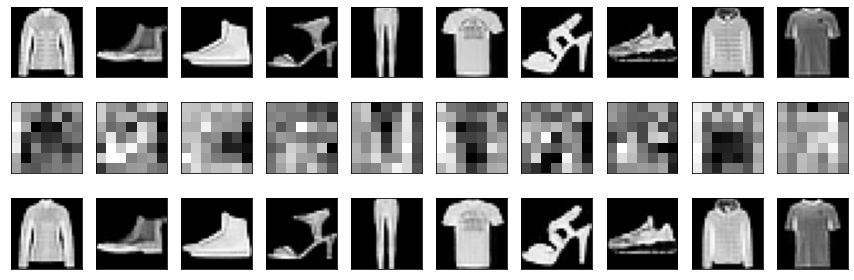

In [19]:
#take 1 batch of the dataset
test_dataset = test_dataset.take(1)

#take the input images and put them in list 
output_sample = []
for input_image, image in tfds.as_numpy(test_dataset):
  output_samples = input_image

#Pick 10 indicies 
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

#Prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

#get the encoder output
encoded = convolutional_encoder_model.predict(conv_output_samples)

#Get a prediction for some values in the dataset 
predicted = convolutional_model.predict(conv_output_samples)

#Display the samples, encodings, and decoded values
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))